In [19]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

In [20]:
# FILE_PATH = "data/adata_rosmap_v3_top1000_s3_k30_drop_nout.h5ad"  # Rosmap 1k
# FILE_PATH = "data/adata_rosmap_v3_top2000_k30_drop.h5ad"  # Rosmap 2k
FILE_PATH = "data/adata_rosmap_v3_top5000_k30_drop.h5ad"  # Rosmap 5k
# FILE_PATH = "data/adata_rosmap_v3_top8000_k30_drop.h5ad"  # Rosmap 8k
# FILE_PATH = ""  # ...

adata_sc = ad.read_h5ad(FILE_PATH)

In [21]:
OUTLIERS = ['11326252', '11624423', '15114174', '15144878', '20147440', '20225925', '20730959', '50101785', '50105725', '50107583']
OUTLIERS = [int(x) for x in OUTLIERS]

DONORS = sorted(adata_sc.obs["Donor ID"].unique())
DONORS = [x for x in DONORS if x not in OUTLIERS]

x = np.zeros((len(DONORS), adata_sc.shape[1]))

for i, donor in enumerate(tqdm(DONORS)):
    adata_donor = adata_sc[adata_sc.obs["Donor ID"] == donor]

    donor_x = adata_donor.X.todense()

    # undo log transformation
    donor_x = np.expm1(donor_x)

    # inflate cells to original counts
    for j in range(donor_x.shape[0]):
        donor_xj_sum = donor_x[j].sum()
        if donor_xj_sum > 0:
            donor_x[j] = donor_x[j] * adata_donor.obs["total_counts"].values[j] / donor_xj_sum
        else:
            donor_x[j] = 0
            print(f"Warning: all zero counts for cell {j} of donor {donor}.")

    # aggregate all cells of this donor to simulate bulk
    x[i] = donor_x.sum(axis=0) 

adata = ad.AnnData(x, obs=adata_sc.obs[adata_sc.obs["Donor ID"].isin(DONORS)].groupby("Donor ID").first(), var=adata_sc.var)
adata.obs["Donor ID"] = DONORS

100%|██████████| 339/339 [02:23<00:00,  2.37it/s]
c:\Users\timo\.conda\envs\pyg\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
# sns.clustermap(adata.X, cmap="viridis", xticklabels=False, yticklabels=False, col_cluster=False)

In [23]:
# first we get the Wang labels

wang_labels = []

for donor in DONORS:
    cogdx = adata.obs[adata.obs["Donor ID"] == donor]["cogdx"].values[0]
    braaksc = adata.obs[adata.obs["Donor ID"] == donor]["braaksc"].values[0]
    ceradsc = adata.obs[adata.obs["Donor ID"] == donor]["ceradsc"].values[0]

    if cogdx == 1 and braaksc <= 3 and ceradsc >= 3:
        label = "CT"
    elif cogdx == 4 and braaksc >= 4 and ceradsc <= 2:
        label = "AD"
    else:
        label = "Other"
    # if cogdx == 1 or cogdx == 2:
    #     label = "CT"
    # elif cogdx == 3 or cogdx == 4:
    #     label = "AD"

    # random label
    # label = np.random.choice(["CT", "AD"])

    wang_labels.append(label)

adata.obs["wang_label"] = wang_labels
adata.obs["wang_label"].value_counts()

wang_label
Other    200
AD        78
CT        61
Name: count, dtype: int64

In [24]:
# remove wang="Other"

adata_noint = adata[adata.obs["wang_label"] != "Other"].copy()

X = adata_noint.X
Y = adata_noint.obs["wang_label"].map({"CT": 0, "AD": 1}).values

X = X / X.sum(axis=1).reshape(-1, 1) * 1e4
# X = np.log1p(X)
X = (X - X.mean(axis=0)) / X.std(axis=0)

<Axes: >

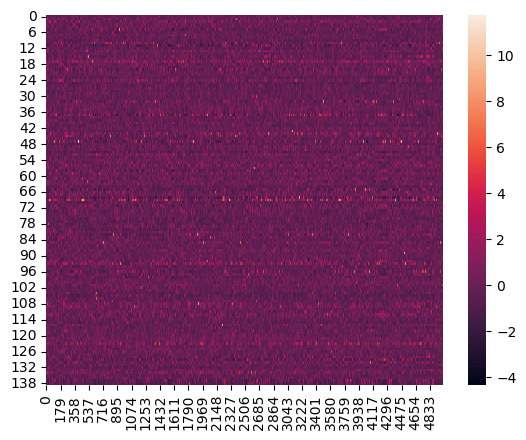

In [25]:
sns.heatmap(X)

In [ ]:
N_RUNS = 100
N_FOLDS = 5
SPLIT_SEED = None
# SPLIT_SEED = 42

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

mean_accs = np.zeros(N_RUNS)
mean_prec = np.zeros(N_RUNS)
mean_rec = np.zeros(N_RUNS)
mean_f1 = np.zeros(N_RUNS)
mean_auc = np.zeros(N_RUNS)

y_pred = []

for j in trange(N_RUNS):

    if SPLIT_SEED is not None:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
    else:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

    test_accs = []
    test_prec = []
    test_rec = []
    test_f1 = []
    test_auc = []
    
    y_pred.append([])

    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        model = Lasso(alpha=0.03)
        model.fit(X_train, Y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_auc.append(roc_auc_score(Y_test, y_pred_test))  # Requires un-rounded predictions

        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)
        
        y_pred[j].append(y_pred_test)
        
        acc_train = (y_pred_train == Y_train).mean()
        acc_test = (y_pred_test == Y_test).mean()
        
        test_accs.append(accuracy_score(Y_test, y_pred_test))
        test_prec.append(precision_score(Y_test, y_pred_test))
        test_rec.append(recall_score(Y_test, y_pred_test))
        test_f1.append(f1_score(Y_test, y_pred_test))
    
    mean_accs[j] = np.mean(test_accs)
    mean_prec[j] = np.mean(test_prec)
    mean_rec[j] = np.mean(test_rec)
    mean_f1[j] = np.mean(test_f1)
    mean_auc[j] = np.mean(test_auc)
    
print(f"Mean test  acc: {np.mean(mean_accs):.4f} +/- {np.std(mean_accs):.4f}")
print(f"Mean test prec: {np.mean(mean_prec):.4f} +/- {np.std(mean_prec):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec):.4f} +/- {np.std(mean_rec):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1):.4f} +/- {np.std(mean_f1):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc):.4f} +/- {np.std(mean_auc):.4f}")

print()

print("acc =", mean_accs)
print("prec =", mean_prec)
print("rec =", mean_rec)
print("f1 =", mean_f1)
print("auc =", mean_auc)

**LASSO alpha=0.03, 1k genes**
```
Mean test  acc: 0.7100 +/- 0.0293
Mean test prec: 0.7425 +/- 0.0305
Mean test  rec: 0.7513 +/- 0.0334
Mean test   f1: 0.7421 +/- 0.0275
Mean test  auc: 0.7744 +/- 0.0234
```

**LASSO alpha=0.03, 2k genes**
```
Mean test  acc: 0.7189 +/- 0.0276
Mean test prec: 0.7474 +/- 0.0279
Mean test  rec: 0.7662 +/- 0.0366
Mean test   f1: 0.7515 +/- 0.0264
Mean test  auc: 0.7842 +/- 0.0248
```

**LASSO alpha=0.03, 5k genes**
```
Mean test  acc: 0.7291 +/- 0.0279
Mean test prec: 0.7536 +/- 0.0267
Mean test  rec: 0.7814 +/- 0.0362
Mean test   f1: 0.7625 +/- 0.0261
Mean test  auc: 0.7935 +/- 0.0293
```

**LASSO alpha=0.03, 8k genes**
```
Mean test  acc: 0.7353 +/- 0.0303
Mean test prec: 0.7537 +/- 0.0294
Mean test  rec: 0.7963 +/- 0.0344
Mean test   f1: 0.7700 +/- 0.0269
Mean test  auc: 0.8080 +/- 0.0248
```

I also tried a 3-layer NN below, but it doesn't perform better.

In [ ]:
# # quickly try a 3-layer neural network with pytorch

# import torch

# dim_h = 512
# dim_h2 = 256

# # 5-fold CV
# N_FOLDS = 5
# N_RUNS = 10

# all_accs = []
# all_prec = []
# all_rec = []
# all_f1 = []
# all_auc = []

# for j in trange(N_RUNS):

#     if SPLIT_SEED is not None:
#         kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
#     else:
#         kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

#     test_accs = []
#     test_prec = []
#     test_rec = []
#     test_f1 = []
#     test_auc = []

#     y_pred.append([])

#     for i, (train_index, test_index) in enumerate(kf.split(X, Y)):

#         net = torch.nn.Sequential(
#             torch.nn.Linear(X.shape[1], dim_h),
#             torch.nn.ReLU(),
#             torch.nn.Linear(dim_h, dim_h2),
#             torch.nn.ReLU(),
#             torch.nn.Linear(dim_h2, 2),
#             torch.nn.Softmax(dim=1),
#         )

#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)

#         X_train = torch.tensor(X[train_index])
#         Y_train = torch.tensor(Y[train_index])

#         X_test = torch.tensor(X[test_index])
#         Y_test = torch.tensor(Y[test_index])

#         prev_loss = 1e10
#         patience = 0
#         saved_model = None

#         train_losses = []
#         test_losses = []

#         for epoch in range(1000):
                
#             optimizer.zero_grad()
#             out = net(X_train.float())
#             loss = criterion(out, Y_train)
#             loss.backward()
#             optimizer.step()

#             loss = loss.detach().numpy()
#             train_losses.append(loss)

#             if loss > prev_loss:
#                 patience += 1
#             else:
#                 patience = 0
#                 prev_loss = loss
#                 saved_model = net.state_dict()

#             if patience > 10:
#                 break

#             # calculate test loss
#             out = net(X_test.float())
#             test_loss = criterion(out, Y_test)
#             test_losses.append(test_loss.detach().numpy())
        
#         net.load_state_dict(saved_model)

#         # test
#         out = net(X_test.float())
#         y_pred_test = out.argmax(dim=1).numpy()

#         acc_test = (y_pred_test == Y_test.numpy()).mean()
#         prec_test = precision_score(Y_test.numpy(), y_pred_test)
#         rec_test = recall_score(Y_test.numpy(), y_pred_test)
#         f1_test = f1_score(Y_test.numpy(), y_pred_test)
#         auc_test = roc_auc_score(Y_test.numpy(), y_pred_test)

#         test_accs.append(acc_test)
#         test_prec.append(prec_test)
#         test_rec.append(rec_test)
#         test_f1.append(f1_test)
#         test_auc.append(auc_test)

#         # import matplotlib.pyplot as plt
#         # plt.figure()
#         # plt.plot(train_losses, label="train")
#         # plt.plot(test_losses, label="test")
#         # plt.legend()
#         # plt.show()

#     print(f"run = {j}, auc = {np.mean(test_auc):.4f}")
#     # print(f"Mean test  acc: {np.mean(test_accs):.4f} +/- {np.std(test_accs):.4f}")
#     # print(f"Mean test prec: {np.mean(test_prec):.4f} +/- {np.std(test_prec):.4f}")
#     # print(f"Mean test  rec: {np.mean(test_rec):.4f} +/- {np.std(test_rec):.4f}")
#     # print(f"Mean test   f1: {np.mean(test_f1):.4f} +/- {np.std(test_f1):.4f}")
#     # print(f"Mean test  auc: {np.mean(test_auc):.4f} +/- {np.std(test_auc):.4f}")

#     all_accs.append(np.mean(test_accs))
#     all_prec.append(np.mean(test_prec))
#     all_rec.append(np.mean(test_rec))
#     all_f1.append(np.mean(test_f1))
#     all_auc.append(np.mean(test_auc))

# print(f"Mean test  acc: {np.mean(all_accs):.4f} +/- {np.std(all_accs):.4f}")
# print(f"Mean test prec: {np.mean(all_prec):.4f} +/- {np.std(all_prec):.4f}")
# print(f"Mean test  rec: {np.mean(all_rec):.4f} +/- {np.std(all_rec):.4f}")
# print(f"Mean test   f1: {np.mean(all_f1):.4f} +/- {np.std(all_f1):.4f}")
# print(f"Mean test  auc: {np.mean(all_auc):.4f} +/- {np.std(all_auc):.4f}")